In [1]:
# Input data
import scipy.io as spio
import numpy as np
from utilities import *
from sklearn.model_selection import train_test_split

In [2]:
# test and train
# input and output
X_train_all, Y_train_all, list_ch_train = read_data(data_path="../data/har-data/", split="train") # train
X_test, Y_test, list_ch_test = read_data(data_path="../data/har-data/", split="test") # test
assert list_ch_train == list_ch_test, "Mistmatch in channels!"
assert Y_train_all.max(axis=0) == Y_test.max(axis=0)
print(np.mean(Y_train_all==0), np.mean(Y_train_all==1), np.mean(Y_train_all==2), np.mean(Y_train_all==3),
     np.mean(Y_train_all==4), np.mean(Y_train_all==5), np.mean(Y_train_all==6), np.mean(Y_train_all==7))

0.0 0.16675734494 0.145946681175 0.134113166485 0.174918389554 0.186887921654 0.191376496192 0.0


In [3]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_all,
                                                      Y_train_all,
                                                      stratify = Y_train_all,
                                                      random_state = 123,
                                                      test_size=0.30)
print(X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape)
print(X_train.dtype, X_valid.dtype, Y_train.dtype, Y_valid.dtype)

(5146, 128, 9) (2206, 128, 9) (5146,) (2206,)
float64 float64 int64 int64


In [4]:
# Standardize/normalize train and test
X_train_norm = (X_train - X_train.mean(axis=0, keepdims=3))/ X_train.std(axis=0, keepdims=3)
X_valid_norm = (X_valid - X_train.mean(axis=0, keepdims=3))/ X_train.std(axis=0, keepdims=3)
X_test_norm = (X_test - X_train.mean(axis=0, keepdims=3))/ X_train.std(axis=0, keepdims=3)

print(X_train_norm.shape, X_train_norm.dtype,
      X_valid_norm.shape, X_valid_norm.dtype,
      X_test_norm.shape, X_test_norm.dtype)

(5146, 128, 9) float64 (2206, 128, 9) float64 (2947, 128, 9) float64


In [5]:
Y_train_onehot = one_hot(labels=Y_train.reshape(-1), n_class=6)
Y_valid_onehot = one_hot(labels=Y_valid.reshape(-1), n_class=6)
Y_test_onehot = one_hot(labels=Y_test.reshape(-1), n_class=6)

print(Y_train_onehot.shape, Y_valid_onehot.shape, 
 X_train_norm.shape, X_valid_norm.shape)

(5146, 6) (2206, 6) (5146, 128, 9) (2206, 128, 9)


In [6]:
### Hyperparameters

# Input data
batch_size = X_train_norm.shape[0]// 100 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial
print('batch_size, seq_len, n_channels', batch_size, seq_len, n_channels)

# Output labels
n_classes = int(Y_train_all.max(axis=0))
print('n_classes', n_classes)

# learning parameters
learning_rate = 0.0001 #1e-4
epochs = 100 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

batch_size, seq_len, n_channels 51 128 9
n_classes 6


In [7]:
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [8]:
#  Buffering/ placeholders to transfer the data from py to tf
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')# Construct the LSTM inputs and LSTM cells

In [9]:
# with graph.as_default():
# (5146, 128, 9) (2206, 128, 9) (5146,) (2206,)
# (batch, 128, 9) --> (batch, 64, 18)
conv1 = tf.layers.conv1d(inputs=inputs_, filters=26, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
# max_pool_1 = tf.nn.dropout(max_pool_1, keep_prob=keep_prob_)
print(conv1.shape, max_pool_1.shape)

# (batch, 64, 18) --> (batch, 32, 36)
conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=36, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
# max_pool_2 = tf.nn.dropout(max_pool_2, keep_prob=keep_prob_)
print(conv2.shape, max_pool_2.shape)

# (batch, 32, 36) --> (batch, 16, 72)
conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=72, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
# max_pool_3 = tf.nn.dropout(max_pool_3, keep_prob=keep_prob_)
print(conv3.shape, max_pool_3.shape)

# (batch, 16, 72) --> (batch, 8, 144)
conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=144, kernel_size=2, strides=1, 
                         padding='same', activation = tf.nn.relu)
max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')
# max_pool_4 = tf.nn.dropout(max_pool_4, keep_prob=keep_prob_)
print(conv4.shape, max_pool_4.shape)

# Flatten and add dropout + predicted output
flat = tf.reshape(max_pool_4, (-1, 8*144))
flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
logits = tf.layers.dense(flat, n_classes)
print(max_pool_4.shape, flat.shape, logits.shape)

(?, 128, 26) (?, 64, 26)
(?, 64, 36) (?, 32, 36)
(?, 32, 72) (?, 16, 72)
(?, 16, 144) (?, 8, 144)
(?, 8, 144) (?, 1152) (?, 6)


In [10]:
# Backward pass: error backpropagation
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
print(correct_pred, accuracy)

Tensor("Equal:0", shape=(?,), dtype=bool) Tensor("accuracy:0", shape=(), dtype=float32)


In [11]:
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []

# Save the training result or trained and validated model params
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            ######################## Training
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : keep_prob, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            ################## Validation
            acc_batch = []
            loss_batch = []    
            # Loop over batches
            for x, y in get_batches(X_valid_norm, Y_valid_onehot, batch_size):

                # Feed dictionary
                feed = {inputs_ : x, labels_ : y, keep_prob_ : 1.0}

                # Loss
                loss, acc = sess.run([cost, accuracy], feed_dict = feed)
                acc_batch.append(acc)
                loss_batch.append(loss)

            # Store
            valid_acc.append(np.mean(acc_batch))
            valid_loss.append(np.mean(loss_batch))
            
        # Print info for every iter/epoch
        print("Epoch: {}/{}".format(e+1, epochs),
              "Train loss: {:6f}".format(np.mean(train_loss)),
              "Valid loss: {:.6f}".format(np.mean(valid_loss)),
              "Train acc: {:6f}".format(np.mean(train_acc)),
              "Valid acc: {:.6f}".format(np.mean(valid_acc)))
                
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 1/100 Train loss: 1.641564 Valid loss: 1.605675 Train acc: 0.223529 Valid acc: 0.254182
Epoch: 2/100 Train loss: 1.485839 Valid loss: 1.447329 Train acc: 0.348628 Valid acc: 0.386938
Epoch: 3/100 Train loss: 1.335508 Valid loss: 1.292867 Train acc: 0.449412 Valid acc: 0.499991
Epoch: 4/100 Train loss: 1.182494 Valid loss: 1.136548 Train acc: 0.525147 Valid acc: 0.582839
Epoch: 5/100 Train loss: 1.044514 Valid loss: 0.996981 Train acc: 0.585922 Valid acc: 0.642026
Epoch: 6/100 Train loss: 0.931177 Valid loss: 0.884307 Train acc: 0.633301 Valid acc: 0.686240
Epoch: 7/100 Train loss: 0.839905 Valid loss: 0.794558 Train acc: 0.670980 Valid acc: 0.719571
Epoch: 8/100 Train loss: 0.766116 Valid loss: 0.722345 Train acc: 0.701250 Valid acc: 0.745851
Epoch: 9/100 Train loss: 0.705446 Valid loss: 0.663075 Train acc: 0.725926 Valid acc: 0.767015
Epoch: 10/100 Train loss: 0.654369 Valid loss: 0.613831 Train acc: 0.746608 Valid acc: 0.784370
Epoch: 11/100 Train loss: 0.610830 Valid loss: 0.

Epoch: 87/100 Train loss: 0.152936 Valid loss: 0.149210 Train acc: 0.937674 Valid acc: 0.941077
Epoch: 88/100 Train loss: 0.151802 Valid loss: 0.148207 Train acc: 0.938091 Valid acc: 0.941431
Epoch: 89/100 Train loss: 0.150704 Valid loss: 0.147215 Train acc: 0.938500 Valid acc: 0.941777
Epoch: 90/100 Train loss: 0.149604 Valid loss: 0.146238 Train acc: 0.938904 Valid acc: 0.942118
Epoch: 91/100 Train loss: 0.148534 Valid loss: 0.145286 Train acc: 0.939298 Valid acc: 0.942452
Epoch: 92/100 Train loss: 0.147475 Valid loss: 0.144343 Train acc: 0.939678 Valid acc: 0.942781
Epoch: 93/100 Train loss: 0.146429 Valid loss: 0.143421 Train acc: 0.940082 Valid acc: 0.943101
Epoch: 94/100 Train loss: 0.145416 Valid loss: 0.142509 Train acc: 0.940467 Valid acc: 0.943422
Epoch: 95/100 Train loss: 0.144392 Valid loss: 0.141619 Train acc: 0.940855 Valid acc: 0.943736
Epoch: 96/100 Train loss: 0.143401 Valid loss: 0.140742 Train acc: 0.941232 Valid acc: 0.944041
Epoch: 97/100 Train loss: 0.142428 Valid

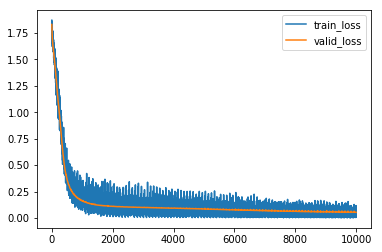

In [12]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss, label='train_loss')
mplot.plot(valid_loss, label='valid_loss')
mplot.legend()
mplot.show()

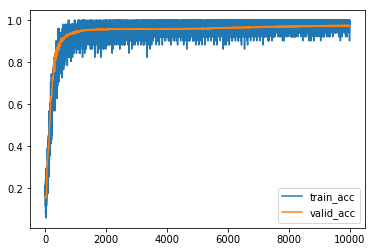

In [13]:
mplot.plot(train_acc, label='train_acc')
mplot.plot(valid_acc, label='valid_acc')
mplot.legend()
mplot.show()

In [14]:
test_acc, test_loss = [], []

with tf.Session() as sess:
    # Restore the validated model
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    ################## Test
    acc_batch = []
    loss_batch = []    
    # Loop over batches
    for x, y in get_batches(X_test_norm, Y_test_onehot, batch_size):

        # Feed dictionary
        feed = {inputs_ : x, labels_ : y, keep_prob_ : 1.0}

        # Loss
        loss, acc = sess.run([cost, accuracy], feed_dict = feed)
        acc_batch.append(acc)
        loss_batch.append(loss)

    # Store
    test_acc.append(np.mean(acc_batch))
    test_loss.append(np.mean(loss_batch))

    # Print info for every iter/epoch
    print("Test loss: {:6f}".format(np.mean(test_loss)),
          "Test acc: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
Test loss: 0.439343 Test acc: 0.917785
